In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("SBUX.csv", index_col = 'Date', parse_dates=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,82.458740,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,84.001450,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,84.439499,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,84.544258,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,83.925262,7296900
...,...,...,...,...,...,...
2020-12-04,101.349998,102.940002,101.070000,102.279999,99.408989,6952700
2020-12-07,102.010002,102.220001,100.690002,101.410004,98.563408,4514800
2020-12-08,100.370003,101.570000,100.010002,101.209999,98.369026,3911300


In [4]:
dataset = df['Volume']
dataset = dataset.values.astype('float32')

In [5]:
tf.random.set_seed(2)

In [6]:
# convert array to matrix
def create_dataset (dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
#normalise the dataset
dataset = dataset.reshape(-1, 1)
mm = MinMaxScaler(feature_range=(0,1))
dataset = mm.fit_transform(dataset)

In [8]:
# spilt into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [9]:
train.shape

(177, 1)

In [10]:
# reshape into X=t, y=t+1
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [11]:
y_train.shape

(175,)

In [12]:
# reshape input to be (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [13]:
# create and fit the LSTM network
model = Sequential()

# 1 input + a hidden layer with 4 LSTM blocks/neurons
# input_shape =  (num_timesteps, num_features)
# The number of neurons in a LSTM layer determines the representational 
# capability of that layer and should be set accordingly based on experiments
model.add(LSTM(50, input_shape=(1, look_back), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
# with dropout=02, loss = 0.023

# output layer that makes a single value prediction
model.add(Dense(1, activation = 'linear'))
# opt = keras.optimizers.Adam(learning_rate = 0.001) #by default lr = 0.01
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size = 1, verbose = 2)
# batch_size = 1 or 10 the same

Epoch 1/100
175/175 - 3s - loss: 0.0432 - 3s/epoch - 15ms/step
Epoch 2/100
175/175 - 0s - loss: 0.0228 - 197ms/epoch - 1ms/step
Epoch 3/100
175/175 - 0s - loss: 0.0189 - 182ms/epoch - 1ms/step
Epoch 4/100
175/175 - 0s - loss: 0.0187 - 206ms/epoch - 1ms/step
Epoch 5/100
175/175 - 0s - loss: 0.0187 - 179ms/epoch - 1ms/step
Epoch 6/100
175/175 - 0s - loss: 0.0174 - 199ms/epoch - 1ms/step
Epoch 7/100
175/175 - 0s - loss: 0.0200 - 187ms/epoch - 1ms/step
Epoch 8/100
175/175 - 0s - loss: 0.0183 - 199ms/epoch - 1ms/step
Epoch 9/100
175/175 - 0s - loss: 0.0181 - 222ms/epoch - 1ms/step
Epoch 10/100
175/175 - 0s - loss: 0.0182 - 217ms/epoch - 1ms/step
Epoch 11/100
175/175 - 0s - loss: 0.0202 - 213ms/epoch - 1ms/step
Epoch 12/100
175/175 - 0s - loss: 0.0166 - 220ms/epoch - 1ms/step
Epoch 13/100
175/175 - 0s - loss: 0.0176 - 207ms/epoch - 1ms/step
Epoch 14/100
175/175 - 0s - loss: 0.0186 - 190ms/epoch - 1ms/step
Epoch 15/100
175/175 - 0s - loss: 0.0182 - 179ms/epoch - 1ms/step
Epoch 16/100
175/175 

In [319]:
# make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# invert predictions
train_pred = mm.inverse_transform(train_pred)
y_train = mm.inverse_transform([y_train])

test_pred = mm.inverse_transform(test_pred)
y_test = mm.inverse_transform([y_test])

# calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], train_pred[:,0]))
print("Train score: %.2f RMSE" % (train_score))

test_score = np.sqrt(mean_squared_error(y_test[0], test_pred[:,0]))
print("Test score: %.2f RMSE" % (test_score))

3/3 [==============================] - 0s 2ms/step
Train score: 3431741.78 RMSE
Test score: 2570912.52 RMSE


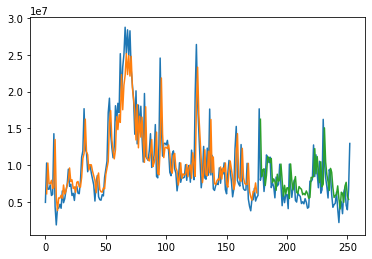

In [320]:
# shift train predictions for plotting
train_pred_plot = np.empty_like(dataset)
train_pred_plot[:,:] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back, :] = train_pred

# shift test predictions for plotting
test_pred_plot = np.empty_like(dataset)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred) + (look_back*2)+1:len(dataset)-1, :] = test_pred

# plot baseline and predictions
plt.plot(mm.inverse_transform(dataset))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()

### Increase window size

In [321]:
dataset = df['Volume']
dataset = dataset.values.astype('float32')
tf.random.set_seed(2)

dataset = dataset.reshape(-1, 1)
mm = MinMaxScaler(feature_range=(0,1))
dataset = mm.fit_transform(dataset)

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [322]:
# increase look_back to increase window size
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [323]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [324]:
# create and fit the LSTM network
model = Sequential()
# 1 input + a hidden layer with 4 LSTM blocks/neurons
model.add(LSTM(50, input_shape=(1, look_back), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2)) 
# output layer that makes a single value prediction
model.add(Dense(1, activation = 'linear'))
opt = keras.optimizers.Adam(learning_rate = 0.001) #by default lr = 0.01
model.compile(loss='mean_squared_error', optimizer=opt)
model.fit(X_train, y_train, epochs=100, batch_size = 1, verbose = 2)
#batch_size=10, loss = 0.0158

Epoch 1/100
173/173 - 2s - loss: 0.0345 - 2s/epoch - 12ms/step
Epoch 2/100
173/173 - 0s - loss: 0.0193 - 189ms/epoch - 1ms/step
Epoch 3/100
173/173 - 0s - loss: 0.0205 - 175ms/epoch - 1ms/step
Epoch 4/100
173/173 - 0s - loss: 0.0217 - 199ms/epoch - 1ms/step
Epoch 5/100
173/173 - 0s - loss: 0.0192 - 184ms/epoch - 1ms/step
Epoch 6/100
173/173 - 0s - loss: 0.0186 - 181ms/epoch - 1ms/step
Epoch 7/100
173/173 - 0s - loss: 0.0191 - 192ms/epoch - 1ms/step
Epoch 8/100
173/173 - 0s - loss: 0.0155 - 176ms/epoch - 1ms/step
Epoch 9/100
173/173 - 0s - loss: 0.0181 - 185ms/epoch - 1ms/step
Epoch 10/100
173/173 - 0s - loss: 0.0183 - 185ms/epoch - 1ms/step
Epoch 11/100
173/173 - 0s - loss: 0.0169 - 182ms/epoch - 1ms/step
Epoch 12/100
173/173 - 0s - loss: 0.0203 - 184ms/epoch - 1ms/step
Epoch 13/100
173/173 - 0s - loss: 0.0180 - 184ms/epoch - 1ms/step
Epoch 14/100
173/173 - 0s - loss: 0.0172 - 182ms/epoch - 1ms/step
Epoch 15/100
173/173 - 0s - loss: 0.0165 - 196ms/epoch - 1ms/step
Epoch 16/100
173/173 

In [105]:
# make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# invert predictions
train_pred = mm.inverse_transform(train_pred)
y_train = mm.inverse_transform([y_train])

test_pred = mm.inverse_transform(test_pred)
y_test = mm.inverse_transform([y_test])

# calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], train_pred[:,0]))
print("Train score: %.2f RMSE" % (train_score))

test_score = np.sqrt(mean_squared_error(y_test[0], test_pred[:,0]))
print("Test score: %.2f RMSE" % (test_score))

3/3 [==============================] - 0s 1ms/step
Train score: 3324109.72 RMSE
Test score: 2333455.82 RMSE


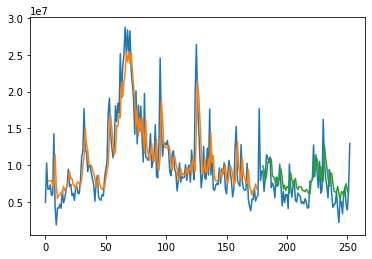

In [106]:
# shift train predictions for plotting
train_pred_plot = np.empty_like(dataset)
train_pred_plot[:,:] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back, :] = train_pred

# shift test predictions for plotting
test_pred_plot = np.empty_like(dataset)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred) + (look_back*2)+1:len(dataset)-1, :] = test_pred

# plot baseline and predictions
plt.plot(mm.inverse_transform(dataset))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()

### Increasing timesteps

In [268]:
dataset = df['Volume']
dataset = dataset.values.astype('float32')
tf.random.set_seed(2)

dataset = dataset.reshape(-1, 1)
mm = MinMaxScaler(feature_range=(0,1))
dataset = mm.fit_transform(dataset)

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [269]:
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [271]:
# create and fit the LSTM network
model = Sequential()
# 1 input + a hidden layer with 4 LSTM blocks/neurons
model.add(LSTM(4, input_shape=(look_back, 1))) 
# output layer that makes a single value prediction
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate = 0.001) #by default lr = 0.01
model.compile(loss='mean_squared_error', optimizer=opt)
model.fit(X_train, y_train, epochs=100, batch_size = 1, verbose = 2)
#batch_size=10, loss = 0.0163

Epoch 1/100
173/173 - 1s - loss: 0.1341 - 1s/epoch - 7ms/step
Epoch 2/100
173/173 - 0s - loss: 0.0485 - 145ms/epoch - 836us/step
Epoch 3/100
173/173 - 0s - loss: 0.0403 - 147ms/epoch - 852us/step
Epoch 4/100
173/173 - 0s - loss: 0.0352 - 149ms/epoch - 861us/step
Epoch 5/100
173/173 - 0s - loss: 0.0312 - 149ms/epoch - 860us/step
Epoch 6/100
173/173 - 0s - loss: 0.0277 - 151ms/epoch - 874us/step
Epoch 7/100
173/173 - 0s - loss: 0.0248 - 148ms/epoch - 854us/step
Epoch 8/100
173/173 - 0s - loss: 0.0220 - 148ms/epoch - 854us/step
Epoch 9/100
173/173 - 0s - loss: 0.0200 - 148ms/epoch - 857us/step
Epoch 10/100
173/173 - 0s - loss: 0.0185 - 151ms/epoch - 874us/step
Epoch 11/100
173/173 - 0s - loss: 0.0179 - 144ms/epoch - 834us/step
Epoch 12/100
173/173 - 0s - loss: 0.0177 - 148ms/epoch - 854us/step
Epoch 13/100
173/173 - 0s - loss: 0.0171 - 148ms/epoch - 854us/step
Epoch 14/100
173/173 - 0s - loss: 0.0173 - 145ms/epoch - 838us/step
Epoch 15/100
173/173 - 0s - loss: 0.0171 - 148ms/epoch - 853us

In [118]:
# make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# invert predictions
train_pred = mm.inverse_transform(train_pred)
y_train = mm.inverse_transform([y_train])

test_pred = mm.inverse_transform(test_pred)
y_test = mm.inverse_transform([y_test])

# calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[0], train_pred[:,0]))
print("Train score: %.2f RMSE" % (train_score))

test_score = np.sqrt(mean_squared_error(y_test[0], test_pred[:,0]))
print("Test score: %.2f RMSE" % (test_score))

3/3 [==============================] - 0s 1ms/step
Train score: 3313048.65 RMSE
Test score: 2329727.68 RMSE


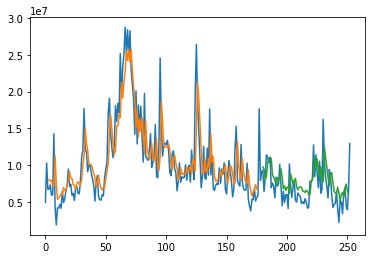

In [119]:
# shift train predictions for plotting
train_pred_plot = np.empty_like(dataset)
train_pred_plot[:,:] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back, :] = train_pred

# shift test predictions for plotting
test_pred_plot = np.empty_like(dataset)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred) + (look_back*2)+1:len(dataset)-1, :] = test_pred

# plot baseline and predictions
plt.plot(mm.inverse_transform(dataset))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()

### Stateful

In [272]:
dataset = df['Volume']
dataset = dataset.values.astype('float32')
tf.random.set_seed(2)

dataset = dataset.reshape(-1, 1)
mm = MinMaxScaler(feature_range=(0,1))
dataset = mm.fit_transform(dataset)

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [273]:
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [276]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
# 1 input + a hidden layer with 4 LSTM blocks/neurons
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True)) 
# output layer that makes a single value prediction
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate = 0.001) #by default lr = 0.01
model.compile(loss='mean_squared_error', optimizer=opt)
for i in range(100):
    model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

173/173 - 1s - loss: 0.0198 - 1s/epoch - 7ms/step
173/173 - 0s - loss: 0.0195 - 143ms/epoch - 827us/step
173/173 - 0s - loss: 0.0195 - 146ms/epoch - 845us/step
173/173 - 0s - loss: 0.0194 - 142ms/epoch - 822us/step
173/173 - 0s - loss: 0.0193 - 143ms/epoch - 826us/step
173/173 - 0s - loss: 0.0191 - 145ms/epoch - 835us/step
173/173 - 0s - loss: 0.0190 - 148ms/epoch - 857us/step
173/173 - 0s - loss: 0.0188 - 146ms/epoch - 842us/step
173/173 - 0s - loss: 0.0187 - 144ms/epoch - 830us/step
173/173 - 0s - loss: 0.0185 - 145ms/epoch - 837us/step
173/173 - 0s - loss: 0.0184 - 145ms/epoch - 837us/step
173/173 - 0s - loss: 0.0183 - 144ms/epoch - 831us/step
173/173 - 0s - loss: 0.0182 - 142ms/epoch - 820us/step
173/173 - 0s - loss: 0.0180 - 146ms/epoch - 845us/step
173/173 - 0s - loss: 0.0179 - 146ms/epoch - 846us/step
173/173 - 0s - loss: 0.0178 - 143ms/epoch - 829us/step
173/173 - 0s - loss: 0.0177 - 172ms/epoch - 996us/step
173/173 - 0s - loss: 0.0176 - 153ms/epoch - 883us/step
173/173 - 0s - 

In [235]:
# make predictions
train_pred = model.predict(X_train, batch_size=batch_size)
model.reset_states()
test_pred = model.predict(X_test, batch_size=batch_size)

# invert predictions
train_pred = mm.inverse_transform(train_pred)
y_train = mm.inverse_transform(y_train)

test_pred = mm.inverse_transform(test_pred)
y_test = mm.inverse_transform(y_test)

# calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[:,0], train_pred[:,0]))
print("Train score: %.2f RMSE" % (train_score))

test_score = np.sqrt(mean_squared_error(y_test[:,0], test_pred[:,0]))
print("Test score: %.2f RMSE" % (test_score))

72/72 [==============================] - 0s 662us/step
Train score: 3376668.50 RMSE
Test score: 2241620.75 RMSE


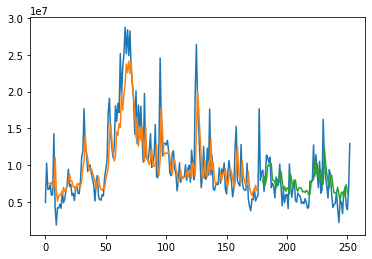

In [224]:
# shift train predictions for plotting
train_pred_plot = np.empty_like(dataset)
train_pred_plot[:,:] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back, :] = train_pred

# shift test predictions for plotting
test_pred_plot = np.empty_like(dataset)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred) + (look_back*2)+1:len(dataset)-1, :] = test_pred

# plot baseline and predictions
plt.plot(mm.inverse_transform(dataset))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()

### Stacked memory between batches

In [277]:
dataset = df['Volume']
dataset = dataset.values.astype('float32')
tf.random.set_seed(2)

dataset = dataset.reshape(-1, 1)
mm = MinMaxScaler(feature_range=(0,1))
dataset = mm.fit_transform(dataset)

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [278]:
look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [281]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
# 1 input + a hidden layer with 4 LSTM blocks/neurons
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1),
               stateful=True, return_sequences=True)) 
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1),
               stateful=True)) 
# dropout = 0.2, loss = 0.0197
          
# output layer that makes a single value prediction
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate = 0.001) #by default lr = 0.01
model.compile(loss='mean_squared_error', optimizer=opt)
for i in range(100):
    model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

173/173 - 2s - loss: 0.0382 - 2s/epoch - 13ms/step
173/173 - 0s - loss: 0.0349 - 248ms/epoch - 1ms/step
173/173 - 0s - loss: 0.0328 - 230ms/epoch - 1ms/step
173/173 - 0s - loss: 0.0310 - 231ms/epoch - 1ms/step
173/173 - 0s - loss: 0.0294 - 228ms/epoch - 1ms/step
173/173 - 0s - loss: 0.0278 - 235ms/epoch - 1ms/step
173/173 - 0s - loss: 0.0265 - 228ms/epoch - 1ms/step
173/173 - 0s - loss: 0.0254 - 230ms/epoch - 1ms/step
173/173 - 0s - loss: 0.0244 - 235ms/epoch - 1ms/step
173/173 - 0s - loss: 0.0238 - 231ms/epoch - 1ms/step
173/173 - 0s - loss: 0.0233 - 339ms/epoch - 2ms/step
173/173 - 0s - loss: 0.0229 - 245ms/epoch - 1ms/step
173/173 - 0s - loss: 0.0227 - 266ms/epoch - 2ms/step
173/173 - 0s - loss: 0.0225 - 249ms/epoch - 1ms/step
173/173 - 0s - loss: 0.0223 - 235ms/epoch - 1ms/step
173/173 - 0s - loss: 0.0222 - 236ms/epoch - 1ms/step
173/173 - 0s - loss: 0.0220 - 245ms/epoch - 1ms/step
173/173 - 0s - loss: 0.0219 - 261ms/epoch - 2ms/step
173/173 - 0s - loss: 0.0218 - 236ms/epoch - 1ms/

In [239]:
# make predictions
train_pred = model.predict(X_train, batch_size=batch_size)
model.reset_states()
test_pred = model.predict(X_test, batch_size=batch_size)

# invert predictions
train_pred = mm.inverse_transform(train_pred)
y_train = mm.inverse_transform(y_train)

test_pred = mm.inverse_transform(test_pred)
y_test = mm.inverse_transform(y_test)

# calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train[:,0], train_pred[:,0]))
print("Train score: %.2f RMSE" % (train_score))

test_score = np.sqrt(mean_squared_error(y_test[:,0], test_pred[:,0]))
print("Test score: %.2f RMSE" % (test_score))

72/72 [==============================] - 0s 1ms/step
Train score: 3609434.00 RMSE
Test score: 2222070.25 RMSE


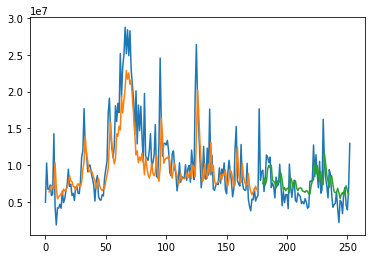

In [240]:
# shift train predictions for plotting
train_pred_plot = np.empty_like(dataset)
train_pred_plot[:,:] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back, :] = train_pred

# shift test predictions for plotting
test_pred_plot = np.empty_like(dataset)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred) + (look_back*2)+1:len(dataset)-1, :] = test_pred

# plot baseline and predictions
plt.plot(mm.inverse_transform(dataset))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()

### Multiple features

In [14]:
df = pd.read_csv("SBUX.csv", index_col = 'Date', parse_dates=True)
dataset = df.values.astype('float32')
tf.random.set_seed(2)

mm = MinMaxScaler(feature_range=(0,1))
dataset = mm.fit_transform(dataset)

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [15]:
# convert array to matrix
def create_dataset_features (dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [16]:
look_back = 1
X_train, y_train = create_dataset_features(train, look_back)
X_test, y_test = create_dataset_features(test, look_back)

In [19]:
X_train.shape

(175, 1, 6)

In [20]:
X_test.shape

(74, 1, 6)

In [329]:
# reshape input to be (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[2]))

In [21]:
# create and fit the LSTM network
model = Sequential()
# 1 input + a hidden layer with 4 LSTM blocks/neurons
model.add(LSTM(4, input_shape=(1, 6))) 
#dropout = 0.2, loss = 0.0072

# output layer that makes a single value prediction
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate = 0.001) #by default lr = 0.01
model.compile(loss='mean_squared_error', optimizer=opt)
model.fit(X_train, y_train, epochs=100, batch_size = 1, verbose = 2)

Epoch 1/100
175/175 - 1s - loss: 0.1505 - 1s/epoch - 7ms/step
Epoch 2/100
175/175 - 0s - loss: 0.0265 - 116ms/epoch - 665us/step
Epoch 3/100
175/175 - 0s - loss: 0.0223 - 127ms/epoch - 726us/step
Epoch 4/100
175/175 - 0s - loss: 0.0213 - 129ms/epoch - 737us/step
Epoch 5/100
175/175 - 0s - loss: 0.0206 - 116ms/epoch - 662us/step
Epoch 6/100
175/175 - 0s - loss: 0.0203 - 130ms/epoch - 741us/step
Epoch 7/100
175/175 - 0s - loss: 0.0202 - 125ms/epoch - 713us/step
Epoch 8/100
175/175 - 0s - loss: 0.0201 - 117ms/epoch - 671us/step
Epoch 9/100
175/175 - 0s - loss: 0.0200 - 121ms/epoch - 692us/step
Epoch 10/100
175/175 - 0s - loss: 0.0200 - 135ms/epoch - 770us/step
Epoch 11/100
175/175 - 0s - loss: 0.0199 - 115ms/epoch - 656us/step
Epoch 12/100
175/175 - 0s - loss: 0.0199 - 121ms/epoch - 689us/step
Epoch 13/100
175/175 - 0s - loss: 0.0199 - 118ms/epoch - 676us/step
Epoch 14/100
175/175 - 0s - loss: 0.0198 - 116ms/epoch - 665us/step
Epoch 15/100
175/175 - 0s - loss: 0.0198 - 118ms/epoch - 676us

In [22]:
# make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# invert predictions
train_pred = mm.inverse_transform(train_pred[:,:])
y_train = mm.inverse_transform(y_train[:,:])

test_pred = mm.inverse_transform(test_pred[:,:])
y_test = mm.inverse_transform(y_test[:,:])

# calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train, train_pred,
                                        multioutput ='uniform_average'))
print("Train score: %.2f RMSE" % (train_score))

test_score = np.sqrt(mean_squared_error(y_test, test_pred,
                                       multioutput ='uniform_average'))
print("Test score: %.2f RMSE" % (test_score))

3/3 [==============================] - 0s 2ms/step


ValueError: non-broadcastable output operand with shape (175,1) doesn't match the broadcast shape (175,6)

In [24]:
X_test

array([[[0.5110508 , 0.52682436, 0.56457424, 0.53791285, 0.5382911 ,
         0.58729774]],

       [[0.5602585 , 0.52024674, 0.60421   , 0.53159404, 0.5321132 ,
         0.22607233]],

       [[0.56713927, 0.5385406 , 0.6159681 , 0.5519773 , 0.5520425 ,
         0.26934046]],

       [[0.58882403, 0.57245636, 0.6336051 , 0.58438647, 0.5837307 ,
         0.27694368]],

       [[0.6063385 , 0.5738952 , 0.6449839 , 0.57358336, 0.5731679 ,
         0.16914287]],

       [[0.607798  , 0.5889003 , 0.6487769 , 0.60578895, 0.6046568 ,
         0.23468213]],

       [[0.645538  , 0.6435766 , 0.6878437 , 0.65267015, 0.6504947 ,
         0.3540159 ]],

       [[0.6891159 , 0.64830434, 0.67646503, 0.6145537 , 0.61322665,
         0.3413018 ]],

       [[0.65763116, 0.6236383 , 0.6692585 , 0.6102731 , 0.60904133,
         0.31577694]],

       [[0.6196829 , 0.61952734, 0.65901756, 0.59274364, 0.5919019 ,
         0.34302896]],

       [[0.6334444 , 0.6041111 , 0.65313864, 0.6019161 , 0.60087013,
 

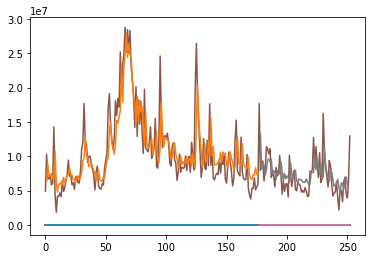

In [175]:
# shift train predictions for plotting
train_pred_plot = np.empty_like(dataset)
train_pred_plot[:,:] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back, :] = train_pred

# shift test predictions for plotting
test_pred_plot = np.empty_like(dataset)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred) + (look_back*2)+1:len(dataset)-1, :] = test_pred

# plot baseline and predictions
plt.plot(mm.inverse_transform(dataset))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()

### Multiple features with increased time steps

In [210]:
df = pd.read_csv("SBUX.csv", index_col = 'Date', parse_dates=True)
dataset = df.values.astype('float32')
tf.random.set_seed(2)

mm = MinMaxScaler(feature_range=(0,1))
dataset = mm.fit_transform(dataset)

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

look_back = 2
X_train, y_train = create_dataset_features(train, look_back)
X_test, y_test = create_dataset_features(test, look_back)

# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[2]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[2]))

In [211]:
X_train.shape

(174, 2, 6)

In [212]:
# create and fit the LSTM network
model = Sequential()
# 1 input + a hidden layer with 4 LSTM blocks/neurons
model.add(LSTM(4, input_shape=(2, 6))) 
# output layer that makes a single value prediction
model.add(Dense(6))
opt = keras.optimizers.Adam(learning_rate = 0.001) #by default lr = 0.01
model.compile(loss='mean_squared_error', optimizer=opt)
model.fit(X_train, y_train, epochs=100, batch_size = 1, verbose = 2)

Epoch 1/100
174/174 - 1s - loss: 0.1849 - 1s/epoch - 7ms/step
Epoch 2/100
174/174 - 0s - loss: 0.0525 - 136ms/epoch - 781us/step
Epoch 3/100
174/174 - 0s - loss: 0.0250 - 130ms/epoch - 749us/step
Epoch 4/100
174/174 - 0s - loss: 0.0179 - 130ms/epoch - 747us/step
Epoch 5/100
174/174 - 0s - loss: 0.0150 - 137ms/epoch - 790us/step
Epoch 6/100
174/174 - 0s - loss: 0.0131 - 135ms/epoch - 776us/step
Epoch 7/100
174/174 - 0s - loss: 0.0115 - 135ms/epoch - 776us/step
Epoch 8/100
174/174 - 0s - loss: 0.0102 - 129ms/epoch - 744us/step
Epoch 9/100
174/174 - 0s - loss: 0.0091 - 140ms/epoch - 804us/step
Epoch 10/100
174/174 - 0s - loss: 0.0082 - 140ms/epoch - 807us/step
Epoch 11/100
174/174 - 0s - loss: 0.0073 - 129ms/epoch - 739us/step
Epoch 12/100
174/174 - 0s - loss: 0.0065 - 140ms/epoch - 805us/step
Epoch 13/100
174/174 - 0s - loss: 0.0059 - 130ms/epoch - 750us/step
Epoch 14/100
174/174 - 0s - loss: 0.0054 - 140ms/epoch - 802us/step
Epoch 15/100
174/174 - 0s - loss: 0.0051 - 125ms/epoch - 718us

In [213]:
# make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# invert predictions
train_pred = mm.inverse_transform(train_pred[:,:])
y_train = mm.inverse_transform(y_train[:,:])

test_pred = mm.inverse_transform(test_pred[:,:])
y_test = mm.inverse_transform(y_test[:,:])

# calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train, train_pred,
                                        multioutput ='uniform_average'))
print("Train score: %.2f RMSE" % (train_score))

test_score = np.sqrt(mean_squared_error(y_test, test_pred,
                                       multioutput ='uniform_average'))
print("Test score: %.2f RMSE" % (test_score))

3/3 [==============================] - 0s 2ms/step
Train score: 1305722.88 RMSE
Test score: 932130.00 RMSE


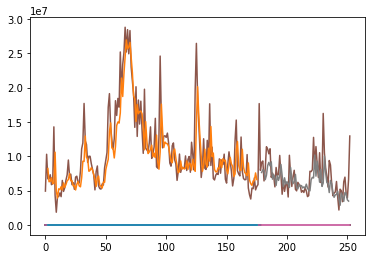

In [214]:
# shift train predictions for plotting
train_pred_plot = np.empty_like(dataset)
train_pred_plot[:,:] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back, :] = train_pred

# shift test predictions for plotting
test_pred_plot = np.empty_like(dataset)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred) + (look_back*2)+1:len(dataset)-1, :] = test_pred

# plot baseline and predictions
plt.plot(mm.inverse_transform(dataset))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()

### Stateful

In [241]:
df = pd.read_csv("SBUX.csv", index_col = 'Date', parse_dates=True)
dataset = df.values.astype('float32')
tf.random.set_seed(2)

mm = MinMaxScaler(feature_range=(0,1))
dataset = mm.fit_transform(dataset)

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

look_back = 2
X_train, y_train = create_dataset_features(train, look_back)
X_test, y_test = create_dataset_features(test, look_back)

# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[2]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[2]))

In [242]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
# 1 input + a hidden layer with 4 LSTM blocks/neurons 
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 6), stateful=True))
# output layer that makes a single value prediction
model.add(Dense(6))
opt = keras.optimizers.Adam(learning_rate = 0.001) #by default lr = 0.01
model.compile(loss='mean_squared_error', optimizer=opt)
for i in range(100):
    model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=2,
              shuffle=False)
    model.reset_states()

174/174 - 1s - loss: 0.2608 - 1s/epoch - 8ms/step
174/174 - 0s - loss: 0.0712 - 146ms/epoch - 842us/step
174/174 - 0s - loss: 0.0321 - 145ms/epoch - 832us/step
174/174 - 0s - loss: 0.0216 - 136ms/epoch - 784us/step
174/174 - 0s - loss: 0.0180 - 135ms/epoch - 775us/step
174/174 - 0s - loss: 0.0160 - 135ms/epoch - 778us/step
174/174 - 0s - loss: 0.0144 - 138ms/epoch - 792us/step
174/174 - 0s - loss: 0.0132 - 136ms/epoch - 779us/step
174/174 - 0s - loss: 0.0121 - 140ms/epoch - 803us/step
174/174 - 0s - loss: 0.0111 - 140ms/epoch - 807us/step
174/174 - 0s - loss: 0.0102 - 133ms/epoch - 762us/step
174/174 - 0s - loss: 0.0094 - 135ms/epoch - 777us/step
174/174 - 0s - loss: 0.0087 - 133ms/epoch - 767us/step
174/174 - 0s - loss: 0.0081 - 131ms/epoch - 755us/step
174/174 - 0s - loss: 0.0075 - 133ms/epoch - 767us/step
174/174 - 0s - loss: 0.0071 - 132ms/epoch - 760us/step
174/174 - 0s - loss: 0.0068 - 131ms/epoch - 753us/step
174/174 - 0s - loss: 0.0066 - 133ms/epoch - 764us/step
174/174 - 0s - 

In [243]:
# make predictions
train_pred = model.predict(X_train, batch_size=batch_size)
model.reset_states()
test_pred = model.predict(X_test, batch_size=batch_size)

# invert predictions
train_pred = mm.inverse_transform(train_pred[:,:])
y_train = mm.inverse_transform(y_train[:,:])

test_pred = mm.inverse_transform(test_pred[:,:])
y_test = mm.inverse_transform(y_test[:,:])

# calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train, train_pred,
                                        multioutput ='uniform_average'))
print("Train score: %.2f RMSE" % (train_score))

test_score = np.sqrt(mean_squared_error(y_test, test_pred,
                                       multioutput ='uniform_average'))
print("Test score: %.2f RMSE" % (test_score))

73/73 [==============================] - 0s 626us/step
Train score: 1316132.25 RMSE
Test score: 927949.56 RMSE


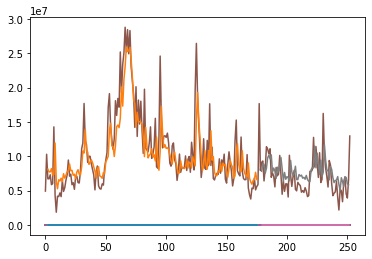

In [244]:
# shift train predictions for plotting
train_pred_plot = np.empty_like(dataset)
train_pred_plot[:,:] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back, :] = train_pred

# shift test predictions for plotting
test_pred_plot = np.empty_like(dataset)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred) + (look_back*2)+1:len(dataset)-1, :] = test_pred

# plot baseline and predictions
plt.plot(mm.inverse_transform(dataset))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()

### Stacked stateful

In [245]:
df = pd.read_csv("SBUX.csv", index_col = 'Date', parse_dates=True)
dataset = df.values.astype('float32')
tf.random.set_seed(2)

mm = MinMaxScaler(feature_range=(0,1))
dataset = mm.fit_transform(dataset)

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

look_back = 2
X_train, y_train = create_dataset_features(train, look_back)
X_test, y_test = create_dataset_features(test, look_back)

# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[2]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[2]))

In [246]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
# 1 input + a hidden layer with 4 LSTM blocks/neurons 
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 6),
               stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 6), stateful=True))
# output layer that makes a single value prediction
model.add(Dense(6))
opt = keras.optimizers.Adam(learning_rate = 0.001) #by default lr = 0.01
model.compile(loss='mean_squared_error', optimizer=opt)
for i in range(100):
    model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=2,
              shuffle=False)
    model.reset_states()

174/174 - 2s - loss: 0.1883 - 2s/epoch - 13ms/step
174/174 - 0s - loss: 0.0514 - 201ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0301 - 202ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0237 - 200ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0201 - 200ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0175 - 201ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0153 - 200ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0133 - 199ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0114 - 201ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0100 - 200ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0091 - 199ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0086 - 200ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0082 - 200ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0080 - 200ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0078 - 221ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0076 - 216ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0075 - 227ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0074 - 234ms/epoch - 1ms/step
174/174 - 0s - loss: 0.0073 - 200ms/epoch - 1ms/

In [247]:
# make predictions
train_pred = model.predict(X_train, batch_size=batch_size)
model.reset_states()
test_pred = model.predict(X_test, batch_size=batch_size)

# invert predictions
train_pred = mm.inverse_transform(train_pred[:,:])
y_train = mm.inverse_transform(y_train[:,:])

test_pred = mm.inverse_transform(test_pred[:,:])
y_test = mm.inverse_transform(y_test[:,:])

# calculate RMSE
train_score = np.sqrt(mean_squared_error(y_train, train_pred,
                                        multioutput ='uniform_average'))
print("Train score: %.2f RMSE" % (train_score))

test_score = np.sqrt(mean_squared_error(y_test, test_pred,
                                       multioutput ='uniform_average'))
print("Test score: %.2f RMSE" % (test_score))

73/73 [==============================] - 0s 737us/step
Train score: 1322819.00 RMSE
Test score: 1323560.62 RMSE


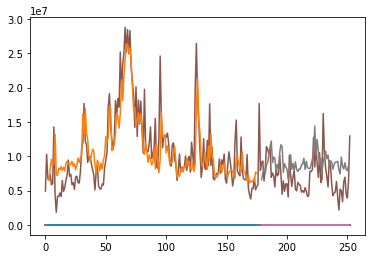

In [248]:
# shift train predictions for plotting
train_pred_plot = np.empty_like(dataset)
train_pred_plot[:,:] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back, :] = train_pred

# shift test predictions for plotting
test_pred_plot = np.empty_like(dataset)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred) + (look_back*2)+1:len(dataset)-1, :] = test_pred

# plot baseline and predictions
plt.plot(mm.inverse_transform(dataset))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()